# 연도별 개인 총소득 분포

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from ipywidgets import widgets
from pathlib import Path

sns.set(font_scale=2)
sns.set_theme(style="whitegrid")

data_dir = Path('/Users/suzinyou/Dropbox/가천대 서울연구원 프로젝트/10. 데이터산출물')
gdrive = Path('/Users/suzinyou/Google Drive/가천대 불평등과 사회정책 연구소/Data')

import plotly.express as px

import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 600
png_renderer.height = 400

In [3]:
pio.renderers.default = "jupyterlab"

In [4]:
stat2ko = {
    'mean': '평균',
    'max': '최대', 'min': '최소', 'std': '표준편차', 'count':''
}
var2ko = {
    'inc_tot': '총소득', 'inc_wage':'근로소득', 'inc_bus':'사업소득', 'prop_txbs_tot':'총재산과세표준',
    'prop_txbs_hs': '주택과세표준'}
def plot_lines(variables, y, title):
    fig = px.line(ds[ds['var'].apply(lambda x: x in variables)], x='STD_YYYY', y=y, color='var')
    fig.update_layout(
        margin={"r":16,"t":72,"l":16,"b":16},
        title=f"서울시 {stat2ko[y]} {title} 추이",
        height=480)
    fig.show()

Preprocessing method

In [5]:
def preprocess_quantiles(_df, _df_toppct):
    df = _df.copy()
    
    # drop null rank (for variables for which null values were excluded from analysis)
    df = df[df['rank'].notnull()]
    df['rank'] = df['rank'] + 1
    df.loc[:, 'rank_sum'] = df['rank_mean'] * df['freq']
    
    yearly_tot = df.groupby(['std_yyyy', 'var']).agg({'rank_sum': 'sum', 'freq':'sum'}).reset_index().rename(columns={'rank_sum':'year_sum', 'freq': 'year_count'})
    df = df.merge(yearly_tot, on=['std_yyyy', 'var'])
    
    df.loc[:, 'share'] = df['rank_sum'] / df['year_sum']
    
    # compute cumulative share to plot Lorenz Curve
    df.loc[:, 'cumshare'] = np.nan
    for g, gdf in df.groupby(['std_yyyy', 'var']):
        year, vname = g
        cs = gdf['share'].cumsum()
        df.loc[(df['std_yyyy'] == year) & (df['var'] == vname), 'cumshare'] = cs
        
    dftp = _df_toppct.copy()
    dftp['rank'] = dftp['rank'] + 1
    dftp = dftp.merge(yearly_tot, on=['std_yyyy', 'var'])
    bottom99 = df.loc[(df['rank'] == 99), ['std_yyyy', 'var', 'cumshare']].rename(columns={'cumshare': 'bottom99'})
    dftp = dftp.merge(bottom99, on=['std_yyyy', 'var'])
    
    dftp.loc[:, 'share'] = dftp['rank_sum'] / dftp['year_sum']
    dftp.loc[:, 'cumshare'] = np.nan
    for g, gdf in dftp.groupby(['std_yyyy', 'var']):
        year, vname = g
        cs = gdf['share'].cumsum() + gdf['bottom99']
        dftp.loc[(dftp['std_yyyy'] == year) & (dftp['var'] == vname), 'cumshare'] = cs
    
    return df, dftp

In [28]:
unit = 'hh'
centiles = pd.read_csv(data_dir / '03_quantiles' / f'seoul_{unit}_centile.csv')
toppct = pd.read_csv(data_dir / '03_quantiles' / f'seoul_{unit}_top1p_1000tile.csv')

In [29]:
centiles, toppct = preprocess_quantiles(centiles, toppct)

In [30]:
centiles.to_csv(data_dir / '03_quantiles' / f'seoul_{unit}_centile+share.csv')
toppct.to_csv(data_dir / '03_quantiles' / f'seoul_{unit}_top1p_1000tile+share.csv')

In [56]:
def gini_full(_df):
    # THis is for when we have individual data!
    gini = (0.5 - np.trapz(np.r_[0,_df['cumshare']], x=np.arange(101) / 100)) / 0.5
    return gini

In [8]:
def gini_quantile(_df):
    # for quantiles
    return (0.5 - np.sum(_df.cumshare * _df['freq'] / _df['freq'].sum())) / 0.5

In [80]:
del g, year, variable, trace1, trace2

In [82]:
centiles.groupby(['std_yyyy', 'var']).cumsum()['freq']/centiles['year_count']

0       0.545516
1       0.550151
2       0.560073
3       0.570163
4       0.580060
          ...   
3915    0.960147
3916    0.970012
3917    0.980009
3918    0.990011
3919    1.000000
Length: 3920, dtype: float64

In [9]:
year = widgets.IntSlider(
    value=2018,
    min=2003,
    max=2018,
    step=1.0,
    description='연도',
    continuous_update=False
)

variable = widgets.Dropdown(
    options=list(centiles['var'].unique()),
    value='inc_tot',
    description='변수',
)

fix_y_range = widgets.Checkbox(
    description='y축 범위 고정?',
    value=True,
)
# Assign an empty figure widget with two traces
trace1 = go.Bar(x=np.arange(1, 101)/100, y=centiles['cumshare'], name="Lorenz Curve")
trace2 = go.Scatter(x=[0, 1.], y=[0, 1.], name="perfect equality",)# fill='tonexty')
g = go.FigureWidget(data=[trace1, trace2],
                    layout=go.Layout(
                        title=dict(
                            text=f'서울 Lorenz Curve (~100분위, {year.value})'
                        ), height=700, width=840))

In [10]:
def response(change):
    filter_mask = (centiles['std_yyyy'] == year.value) & (centiles['var'] == variable.value)
    _df = centiles[filter_mask]

    x1 = _df['freq'].cumsum() / _df['year_count']
    gini = (0.5 - np.sum(_df.cumshare * _df['freq'] / _df['year_count'])) / 0.5
    
    with g.batch_update():
        g.data[0].x = x1
        g.data[0].y = _df['cumshare']
        g.layout.xaxis.title = '누적 인구비율'
        g.layout.yaxis.title = f'누적 점유율'    
        g.layout.title.text = f'{year.value}년 서울 {var2ko[variable.value]} Lorenz Curve (~100분위, Gini={gini:.3f})'
#         if fix_y_range.value:
#             if variable.value == 'inc_tot':
#                 g.layout.yaxis.range = [0., 500*1e6]
#             elif variable.value == 'inc_wage':
#                 g.layout.yaxis.range = [0., 400*1e6]
#             else:
#                 g.layout.yaxis.range = [0., 1.4*1e9]
#         else:
#             g.layout.yaxis.autorange = True
year.observe(response, names="value")
# fix_y_range.observe(response, names="value")
variable.observe(response, names="value")

In [11]:
container = widgets.HBox(children=[variable, year])

widgets.VBox([container, g])

In [31]:
gini = {'std_yyyy':[], 'var':[], 'gini':[]}
for g, _df in centiles.groupby(['std_yyyy', 'var']):
    gini['std_yyyy'].append(g[0])
    gini['var'].append(g[1])
    gini['gini'].append((0.5 - np.sum(_df.cumshare * _df['freq'] / _df['year_count'])) / 0.5)

In [32]:
gini_approx = pd.DataFrame(gini)

In [33]:
pio.renderers.default = "png"

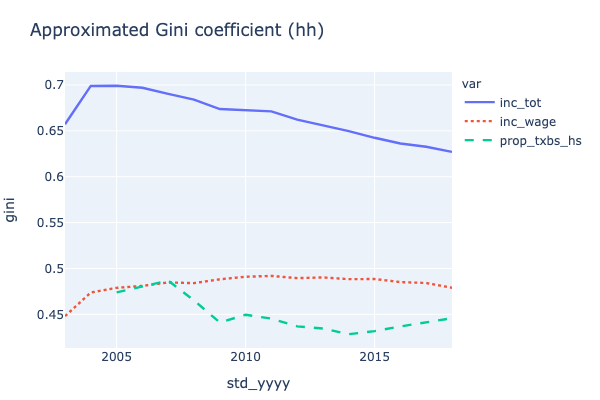

In [35]:
fig = px.line(gini_approx, x="std_yyyy", y="gini", color='var', line_dash='var', 
              title=f"Approximated Gini coefficient ({unit})",
              width=50*12, height=50*8)
fig.update_traces(line=dict(width=2.4))
fig.update_layout(margin={"r":16,"t":72,"l":16,"b":16}, plot_bgcolor='rgba(235,242,249,1)')
fig.show()

In [18]:
def save_lorenz_curve(df, unit, year, var):
    filter_mask = (df['std_yyyy'] == year) & (df['var'] == var)
    _df = df[filter_mask]

    gini = (0.5 - np.sum(_df.cumshare * _df['freq'] / _df['year_count'])) / 0.5    
    t1 = go.Bar(x=_df['freq'].cumsum() / _df['year_count'], 
                y=_df['cumshare'], name="Lorenz Curve")
    t2 = go.Scatter(x=[0, 1.], y=[0, 1.], name="perfect equality",)# fill='tonexty')

    fig = go.Figure(data=[t1, t2],
                    layout=go.Layout(
                    xaxis=dict(title='누적인구비율'),
                    yaxis=dict(title='누적점유율'),
                    title=dict(
                        text=f'{year}년 서울 {var2ko[var]} Lorenz Curve (~100분위, Gini={gini:.3f})'
                    ), height=700, width=840))
    fig.write_image(f"../reports/figures/lorenz_curve_approx_{unit}-{year}-{var}.png")

In [19]:
for y in [2006, 2010, 2014, 2018]:
    for v in ['inc_wage', 'inc_tot', 'prop_txbs_hs']:
        save_lorenz_curve(centiles, 'eq', y, v)

In [36]:
income_groups = [
        'Bottom 20%',
        'Next 30%',
        'Bottom 50%',
        'Middle 40%',
        'Top 10%',
        'Top 1%',
        'Top 0.1%']

In [37]:
def get_income_share_summary(df_centile, df_toppct):
    masks = {
        'Bottom 20%': df_centile['rank'] < 20,
        'Next 30%': (df_centile['rank'] >= 30) & (df_centile['rank'] < 50),
        'Bottom 50%': df_centile['rank'] < 50,
        'Middle 40%': (df_centile['rank'] >= 50) & (df_centile['rank'] < 90),
        'Top 10%': df_centile['rank'] >= 90,
        'Top 1%': df_centile['rank'] == 100,
        'Top 0.1%': df_toppct['rank'] == 10,
    }
    results = list()
    
    groupcols = ['std_yyyy', 'var']
    cols = groupcols + ['share']
    for name, m in masks.items():
        if name == 'Top 0.1%':
            shares = df_toppct.loc[m, cols].groupby(groupcols).sum().reset_index()
        else:
            shares = df_centile.loc[m, cols].groupby(groupcols).sum().reset_index()
        shares.loc[:, 'income_group'] = name
        results.append(shares)
    return pd.concat(results, axis=0)[['var', 'std_yyyy', 'income_group', 'share']].sort_values(by=['std_yyyy', 'var'])

In [38]:
res = get_income_share_summary(centiles, toppct)

In [39]:
res.to_csv(data_dir / f"seoul_{unit}_income_share.csv", index=False)

In [99]:
pio.renderers.default = "png"

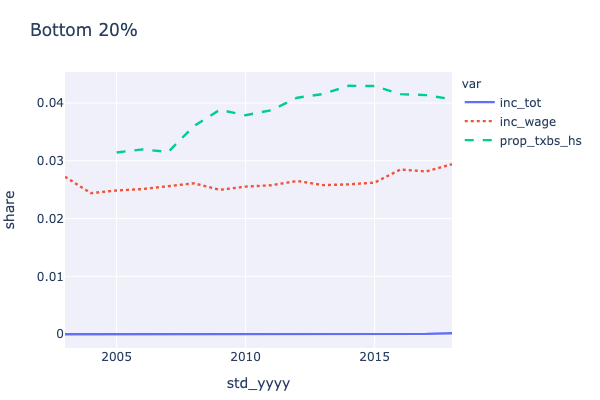

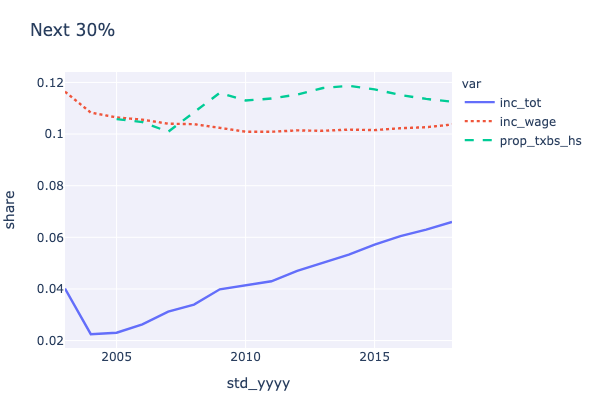

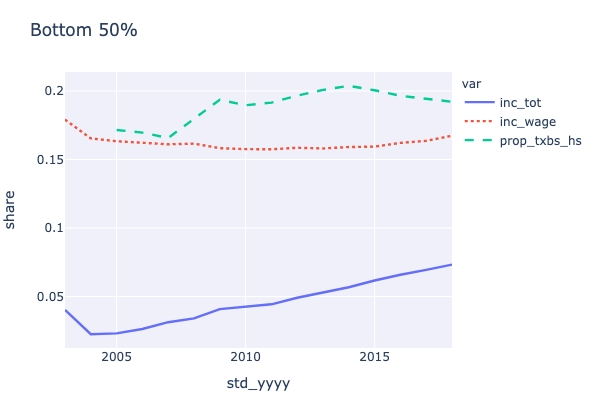

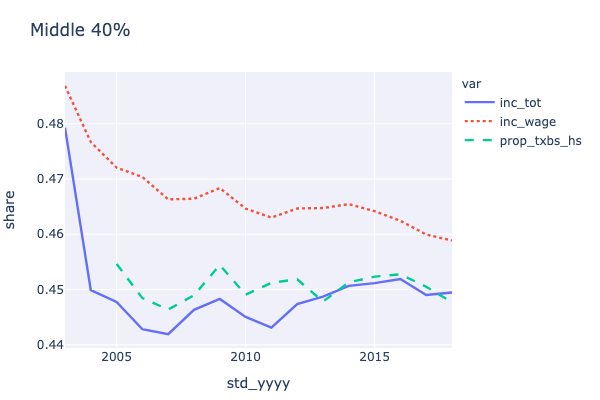

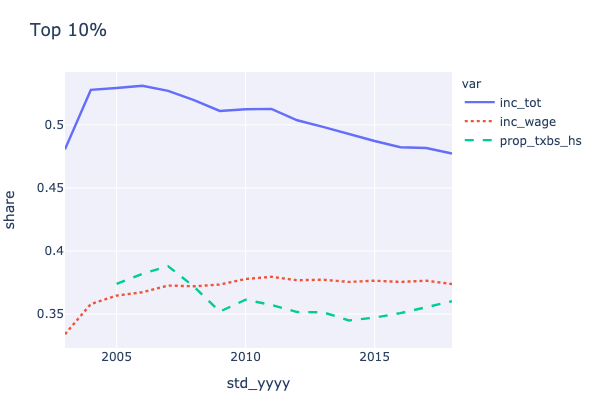

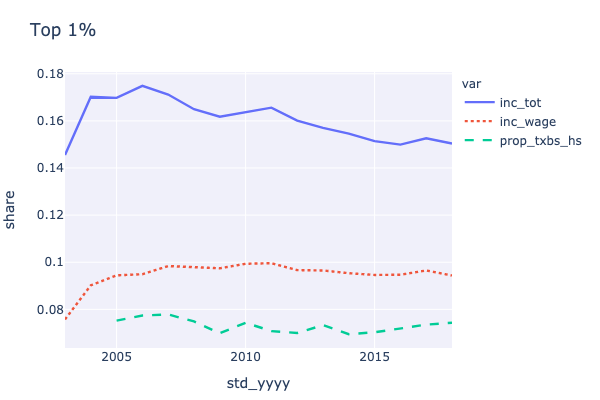

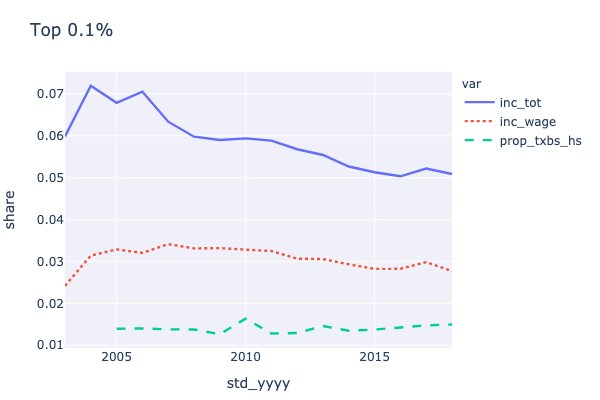

In [40]:
for g in income_groups:
    fig = px.line(res[res['income_group'] == g], x="std_yyyy", y="share", color='var', line_dash='var', 
                  title=f"{g}",
                  width=50*12, height=50*8)
    fig.update_traces(line=dict(width=2.4))
    fig.update_layout(margin={"r":16,"t":72,"l":16,"b":16}, plot_bgcolor='rgba(240,240,250,1)')
    fig.show()

In [167]:
gaibja = pd.read_csv(data_dir / '05_household' / 'seoul_hh_gaibjatype.csv')

<AxesSubplot:xlabel='STD_YYYY', ylabel='MEDIAN'>

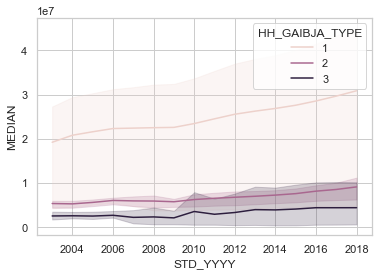

In [172]:
sns.lineplot(data=gaibja, x='std_yyyy'.upper(), y='MEDIAN', hue='HH_GAIBJA_TYPE')

In [171]:
gaibja.head()

,STD_YYYY,HH_GAIBJA_TYPE,COUNT,VAR,MEAN,MEDIAN
0,2002,1,2249698,inc_tot,NaN,NaN
1,2003,1,2156432,inc_tot,3.712406e+07,27306490.0
2,2004,1,2035889,inc_tot,4.216389e+07,29433200.0
3,2005,1,2133308,inc_tot,4.380081e+07,30312980.0
4,2006,1,2274651,inc_tot,4.586276e+07,31222900.0
